In [ ]:
import requests
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor
import time
import plotly.express as px


In [ ]:
API_KEY = "YOUR API KEY HERE"

TRAFFIC_DATA_POINTS = [
    {"lat": 31.5497, "lng": 74.3436, "location": "Lahore"},  # Lahore
    {"lat": 33.6844, "lng": 73.0479, "location": "Islamabad"},  # Islamabad
    {"lat": 24.8607, "lng": 67.0011, "location": "Karachi"},  # Karachi
    {"lat": 34.0151, "lng": 71.5249, "location": "Peshawar"},  # Peshawar
    {"lat": 30.1798, "lng": 66.9750, "location": "Quetta"}  # Quetta
]


In [ ]:
def fetch_travel_time_and_distance(origin, destination, departure_time):
    """Simulate an API call with variability in congestion levels."""
    print(f"Simulating API call for origin={origin}, destination={destination}, time={departure_time}")

    # Generate random normal_time (base travel time in seconds)
    normal_time = random.randint(500, 1500)  # Between 500 seconds (8.3 mins) and 1500 seconds (25 mins)

    # Generate random travel_time with additional delay
    delay = random.randint(0, 1000)  # Add delay of up to 1000 seconds (16.7 mins)
    travel_time = normal_time + delay

    # Return simulated response
    return {
        "rows": [
            {
                "elements": [
                    {
                        "duration_in_traffic": {"value": travel_time},
                        "duration": {"value": normal_time},
                    }
                ]
            }
        ]
    }

In [ ]:
def generate_timestamps(start_year, end_year):
    start_date = datetime(start_year, 1, 1)
    end_date = datetime(end_year, 12, 31)
    timestamps = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]
    print(f"Generated {len(timestamps)} timestamps from {start_date} to {end_date}.")
    return timestamps


In [ ]:
def fetch_historical_traffic_data(points, timestamps):
    """Fetch traffic data for all points and timestamps."""
    all_data = []

    def fetch_data_for_point_and_time(point, timestamp):
        """Helper function to fetch data for a specific point and time."""
        epoch_time = int(timestamp.timestamp())  # Convert to epoch time
        origin = f"{point['lat']},{point['lng']}"
        location_name = point["location"]

        print(f"Fetching data for {location_name} at {timestamp}...")  # Debug log

        try:
            data = fetch_travel_time_and_distance(origin, origin, epoch_time)
            #print(f"API response for {location_name} at {timestamp}: {data}")  # Print raw response for debugging

            # Validate API response structure
            if "rows" in data and data["rows"]:
                elements = data["rows"][0].get("elements", [{}])[0]
                travel_time = elements.get("duration_in_traffic", {}).get("value", None)
                normal_time = elements.get("duration", {}).get("value", None)

                if travel_time is not None and normal_time is not None and normal_time > 0:
                    congestion_level = (travel_time - normal_time) / normal_time
                else:
                    print(f"Missing or invalid data for {location_name} at {timestamp}. Setting default.")
                    congestion_level = 0  # Default to 0 if data is missing

                return {
                    "location": location_name,
                    "timestamp": timestamp,
                    "congestion_level": congestion_level,
                }
            else:
                print(f"Invalid API response structure for {location_name} at {timestamp}: {data}")
        except Exception as e:
            print(f"Error fetching data for {location_name} at {timestamp}: {e}")
        return None

    # Parallel processing with ThreadPoolExecutor
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        tasks = [
            executor.submit(fetch_data_for_point_and_time, point, timestamp)
            for timestamp in timestamps
            for point in points
        ]

        for future in concurrent.futures.as_completed(tasks):
            result = future.result()
            if result:
                all_data.append(result)

    print(f"Fetched data for {len(all_data)} records.")
    return pd.DataFrame(all_data)


In [ ]:
timestamps = generate_timestamps(2023, 2024)

# Fetch historical traffic data
historical_traffic_data = fetch_historical_traffic_data(TRAFFIC_DATA_POINTS, timestamps)

# Save to CSV
historical_traffic_data.to_csv("historical_traffic_data_full.csv", index=False)
print("Historical Traffic Data Preview:\n", historical_traffic_data.head())

# Check data coverage
if not historical_traffic_data.empty:
    print("Data Collected for Each Location:\n", historical_traffic_data["location"].value_counts())
    print("Data Collected for Each Date:\n", historical_traffic_data["timestamp"].dt.date.value_counts())
else:
    print("No data was fetched.")

Streaming output truncated to the last 5000 lines.
Fetching data for Lahore at 2023-08-24 00:00:00...
Simulating API call for origin=31.5497,74.3436, destination=31.5497,74.3436, time=1692835200
Fetching data for Islamabad at 2023-08-24 00:00:00...
Simulating API call for origin=33.6844,73.0479, destination=33.6844,73.0479, time=1692835200
Fetching data for Karachi at 2023-08-24 00:00:00...
Simulating API call for origin=24.8607,67.0011, destination=24.8607,67.0011, time=1692835200
Fetching data for Peshawar at 2023-08-24 00:00:00...
Simulating API call for origin=34.0151,71.5249, destination=34.0151,71.5249, time=1692835200
Fetching data for Quetta at 2023-08-24 00:00:00...
Simulating API call for origin=30.1798,66.975, destination=30.1798,66.975, time=1692835200
Fetching data for Lahore at 2023-08-25 00:00:00...
Simulating API call for origin=31.5497,74.3436, destination=31.5497,74.3436, time=1692921600
Fetching data for Islamabad at 2023-08-25 00:00:00...
Simulating API call for ori

In [ ]:
def preprocess_data(df):
    # Check initial row count
    print(f"Initial row count: {len(df)}")

    # Check for missing values
    print("Checking for missing values:")
    print(df.isna().sum())

    # Convert timestamp to datetime
    try:
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
        print("Timestamps converted to datetime.")
    except Exception as e:
        print(f"Error converting timestamps: {e}")
        return df  # Return unmodified DataFrame in case of an error

    # Drop rows with invalid timestamps
    invalid_timestamps = df["timestamp"].isna().sum()
    if invalid_timestamps > 0:
        print(f"Dropping {invalid_timestamps} rows with invalid timestamps.")
        df.dropna(subset=["timestamp"], inplace=True)

    # Check row count after timestamp cleaning
    print(f"Row count after timestamp cleaning: {len(df)}")

    # Check if standard deviation is zero before normalization
    if df["congestion_level"].std() == 0:
        print("Standard deviation of congestion_level is 0. Setting normalized values to 0.")
        df["congestion_level_normalized"] = 0
    else:
        # Normalize congestion levels
        df["congestion_level_normalized"] = (
            df["congestion_level"] - df["congestion_level"].mean()
        ) / df["congestion_level"].std()
        print("Congestion levels normalized.")

    # Check final row count
    print(f"Final row count: {len(df)}")

    return df


In [ ]:
historical_traffic_data = fetch_historical_traffic_data(TRAFFIC_DATA_POINTS, generate_timestamps(2023, 2024))
historical_traffic_data = preprocess_data(historical_traffic_data)
print("Preprocessed Data Preview:\n", historical_traffic_data.head())


Streaming output truncated to the last 5000 lines.
Fetching data for Lahore at 2023-08-22 00:00:00...
Simulating API call for origin=31.5497,74.3436, destination=31.5497,74.3436, time=1692662400
Fetching data for Islamabad at 2023-08-22 00:00:00...
Simulating API call for origin=33.6844,73.0479, destination=33.6844,73.0479, time=1692662400
Fetching data for Karachi at 2023-08-22 00:00:00...
Simulating API call for origin=24.8607,67.0011, destination=24.8607,67.0011, time=1692662400
Fetching data for Peshawar at 2023-08-22 00:00:00...
Simulating API call for origin=34.0151,71.5249, destination=34.0151,71.5249, time=1692662400
Fetching data for Quetta at 2023-08-22 00:00:00...
Simulating API call for origin=30.1798,66.975, destination=30.1798,66.975, time=1692662400
Fetching data for Lahore at 2023-08-23 00:00:00...
Simulating API call for origin=31.5497,74.3436, destination=31.5497,74.3436, time=1692748800
Fetching data for Islamabad at 2023-08-23 00:00:00...
Simulating API call for ori

In [ ]:
def calculate_energy_consumption(df):
    df["energy_consumption"] = df["congestion_level"].apply(
        lambda x: np.random.uniform(2.5, 3.5) if x > 0.5 else np.random.uniform(1.0, 2.0)
    )
    return df

historical_data_with_energy = calculate_energy_consumption(historical_traffic_data)

In [ ]:
def plot_energy_consumption(df):
    # Distribution of energy consumption
    plt.figure(figsize=(12, 6))
    sns.histplot(df["energy_consumption"], bins=20, kde=True, color="green", alpha=0.7, edgecolor="black")
    plt.title("Distribution of Energy Consumption", fontsize=16)
    plt.xlabel("Energy Consumption (kWh)", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Compare average energy consumption by city
    avg_energy_by_city = df.groupby("location")["energy_consumption"].mean().sort_values()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=avg_energy_by_city.index, y=avg_energy_by_city.values, palette="Greens_d")
    plt.title("Average Energy Consumption by City", fontsize=16)
    plt.xlabel("City", fontsize=14)
    plt.ylabel("Average Energy Consumption (kWh)", fontsize=14)
    for i, val in enumerate(avg_energy_by_city.values):
        plt.text(i, val + 0.02, f"{val:.2f}", ha="center", fontsize=12)
    plt.tight_layout()
    plt.show()


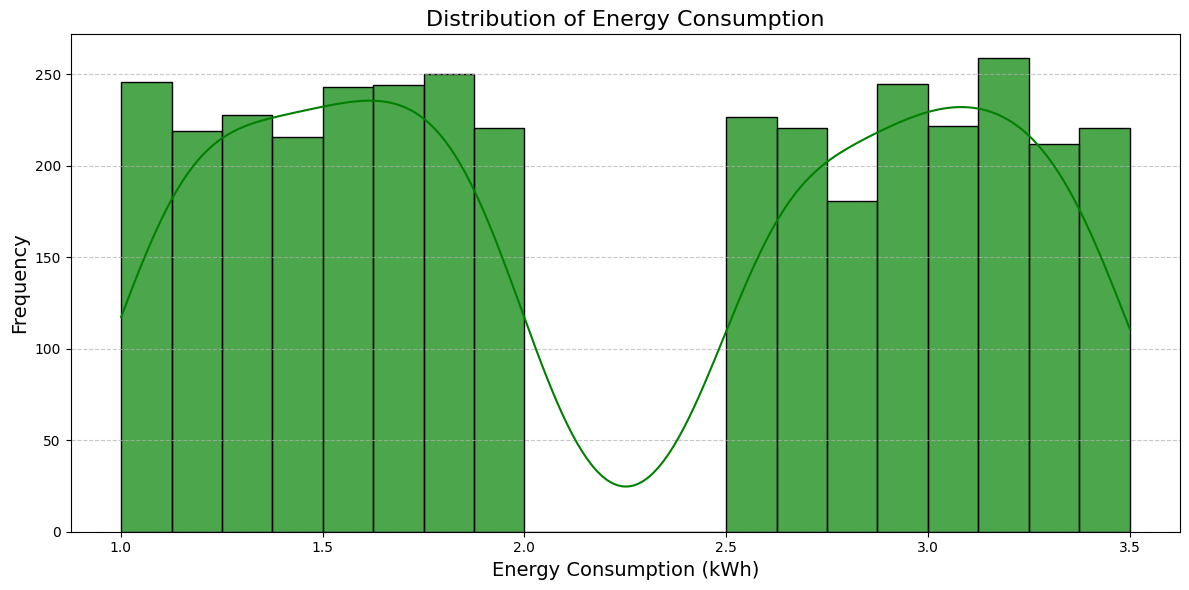

<ipython-input-138-437a8e1290ae>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




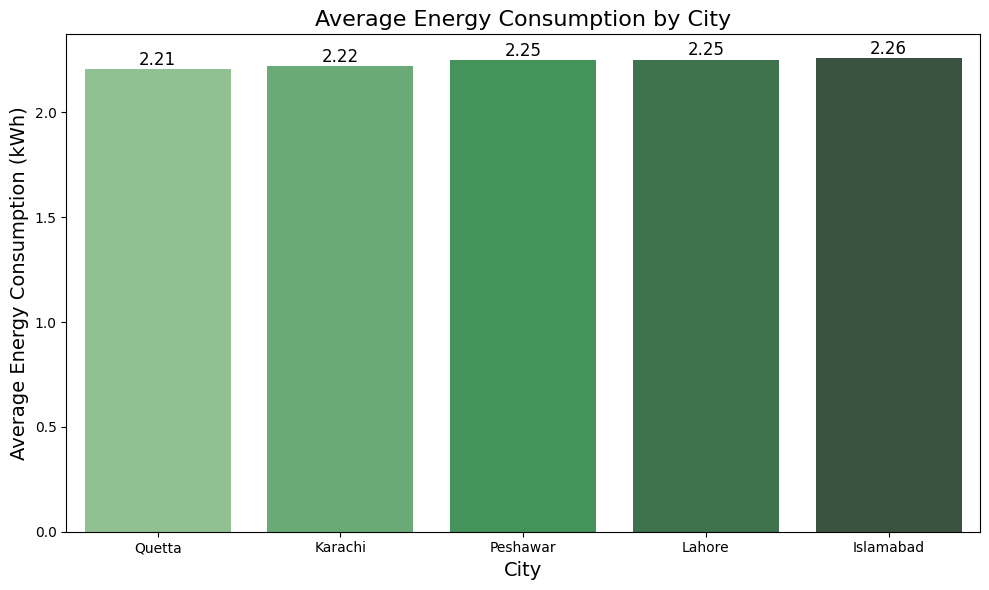

In [ ]:
plot_energy_consumption(historical_data_with_energy)

In [ ]:
def plot_avg_monthly_congestion(df):
    df["month"] = df["timestamp"].dt.to_period("M")  # Extract year-month
    avg_congestion_by_month = df.groupby("month")["congestion_level"].mean()

    plt.figure(figsize=(14, 6))
    avg_congestion_by_month.plot(kind="line", marker="o", color="blue", linewidth=2, alpha=0.8)
    plt.title("Average Monthly Congestion Level", fontsize=16)
    plt.xlabel("Month", fontsize=14)
    plt.ylabel("Average Congestion Level", fontsize=14)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


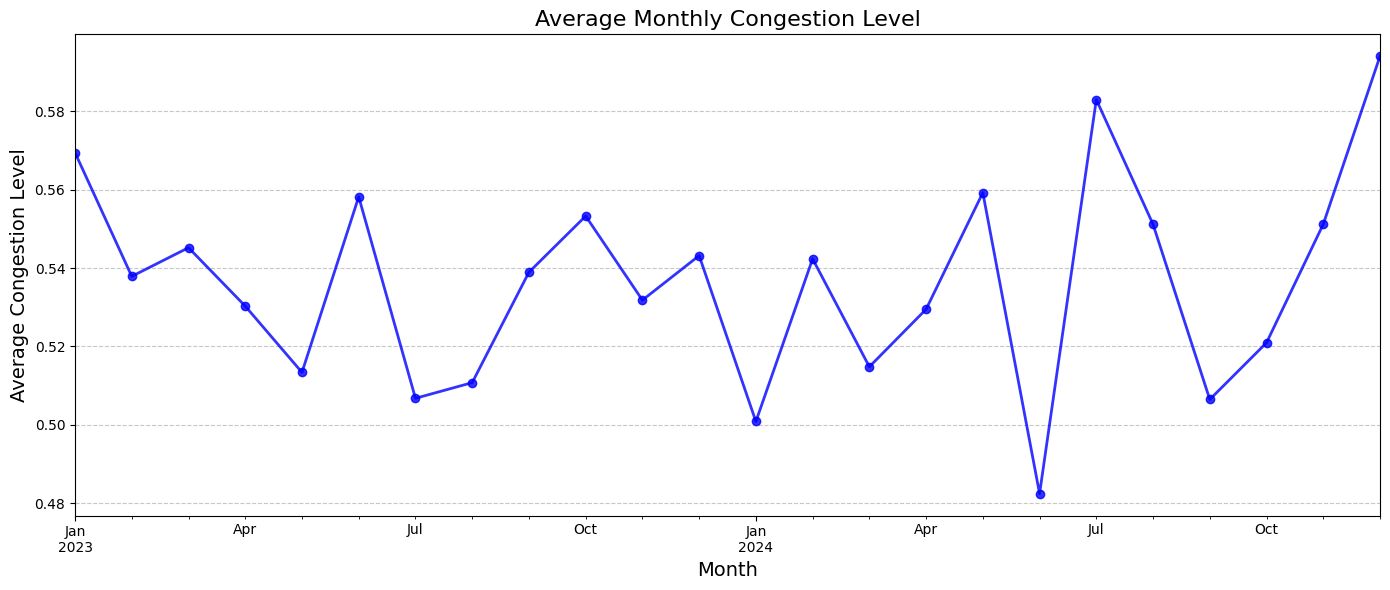

In [ ]:
plot_avg_monthly_congestion(historical_data_with_energy)


In [ ]:
def plot_avg_congestion_by_city(df):
    avg_congestion_by_city = df.groupby("location")["congestion_level"].mean().sort_values()

    plt.figure(figsize=(10, 10))
    sns.barplot(x=avg_congestion_by_city.index, y=avg_congestion_by_city.values, palette="coolwarm")
    plt.title("Average Congestion Level by City", fontsize=16)
    plt.xlabel("City", fontsize=14)
    plt.ylabel("Average Congestion Level", fontsize=18)
    for i, val in enumerate(avg_congestion_by_city.values):
        plt.text(i, val + 0.02, f"{val:.2f}", ha="center", fontsize=12)
    plt.tight_layout()
    plt.show()


<ipython-input-142-97275c20627d>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




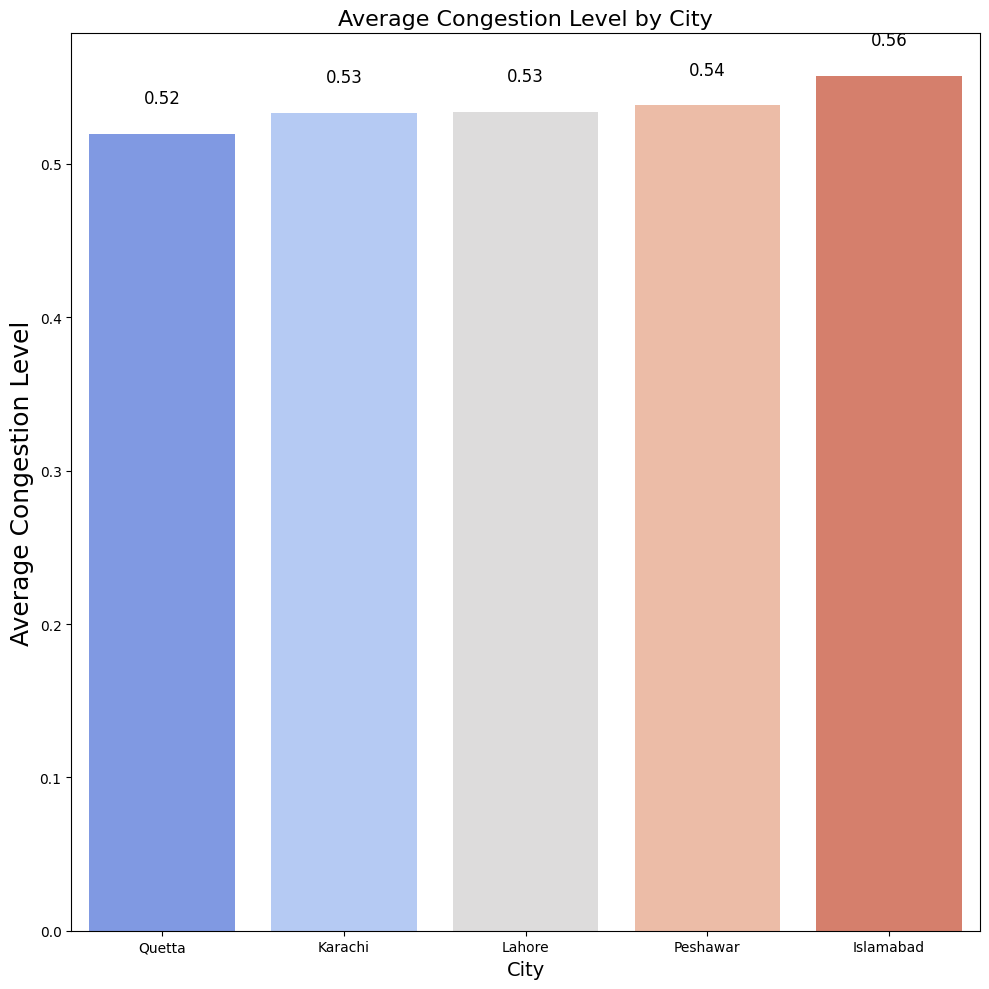

In [ ]:
plot_avg_congestion_by_city(historical_data_with_energy)


In [ ]:
def plot_congestion_energy_correlation(df):
    plt.figure(figsize=(8, 6))
    sns.regplot(x="congestion_level", y="energy_consumption", data=df, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
    plt.title("Correlation Between Congestion Level and Energy Consumption", fontsize=16)
    plt.xlabel("Congestion Level", fontsize=14)
    plt.ylabel("Energy Consumption (kWh)", fontsize=14)
    plt.tight_layout()
    plt.show()


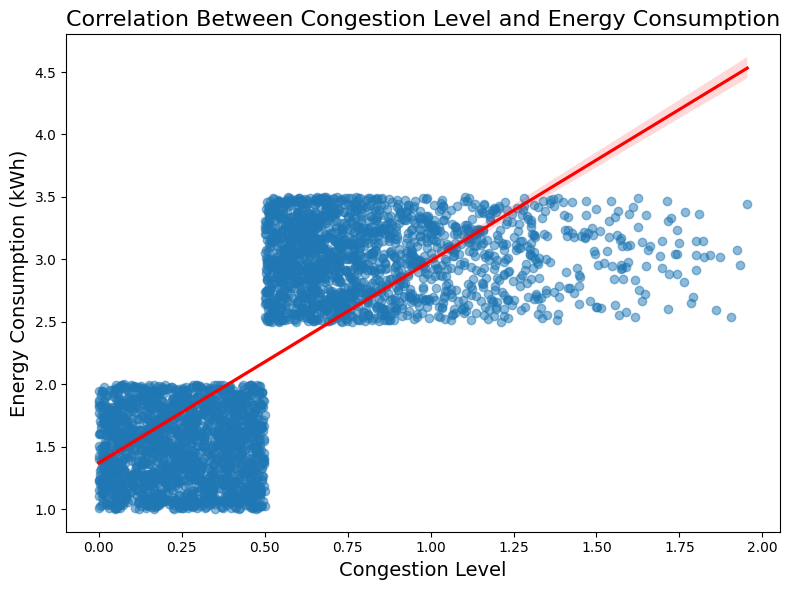

In [ ]:
plot_congestion_energy_correlation(historical_data_with_energy)


In [ ]:
def generate_summary_statistics(df):
    summary = df.groupby("location").agg({
        "congestion_level": ["mean", "std", "max"],
        "energy_consumption": ["mean", "std", "max"]
    }).reset_index()
    summary.columns = ["City", "Avg Congestion", "Std Congestion", "Max Congestion",
                       "Avg Energy", "Std Energy", "Max Energy"]
    print("\nSummary Statistics by City:")
    print(summary)
    return summary


In [ ]:
summary = generate_summary_statistics(historical_data_with_energy)



Summary Statistics by City:
        City  Avg Congestion  Std Congestion  Max Congestion  Avg Energy  \
0  Islamabad        0.557308        0.373930        1.933594    2.259567   
1    Karachi        0.533251        0.377681        1.799277    2.220598   
2     Lahore        0.533947        0.355597        1.954455    2.252259   
3   Peshawar        0.538269        0.363853        1.924901    2.249424   
4     Quetta        0.519850        0.376379        1.870722    2.206354   

   Std Energy  Max Energy  
0    0.803786    3.499697  
1    0.817887    3.495262  
2    0.799661    3.499450  
3    0.808805    3.499226  
4    0.793821    3.492843  


In [ ]:
def plot_monthly_congestion_trends(df):
    # Aggregate data by city and month
    df["month"] = df["timestamp"].dt.to_period("M")
    monthly_avg = df.groupby(["month", "location"])["congestion_level"].mean().reset_index()
    monthly_avg["month"] = monthly_avg["month"].dt.to_timestamp()  # Convert period to timestamp for plotting

    plt.figure(figsize=(14, 8))
    for city in df["location"].unique():
        city_data = monthly_avg[monthly_avg["location"] == city]
        plt.plot(city_data["month"], city_data["congestion_level"], label=city, linewidth=2, marker='o', alpha=0.8)

    plt.title("Monthly Average Congestion Levels by City", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Average Congestion Level", fontsize=14)
    plt.legend(title="City", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


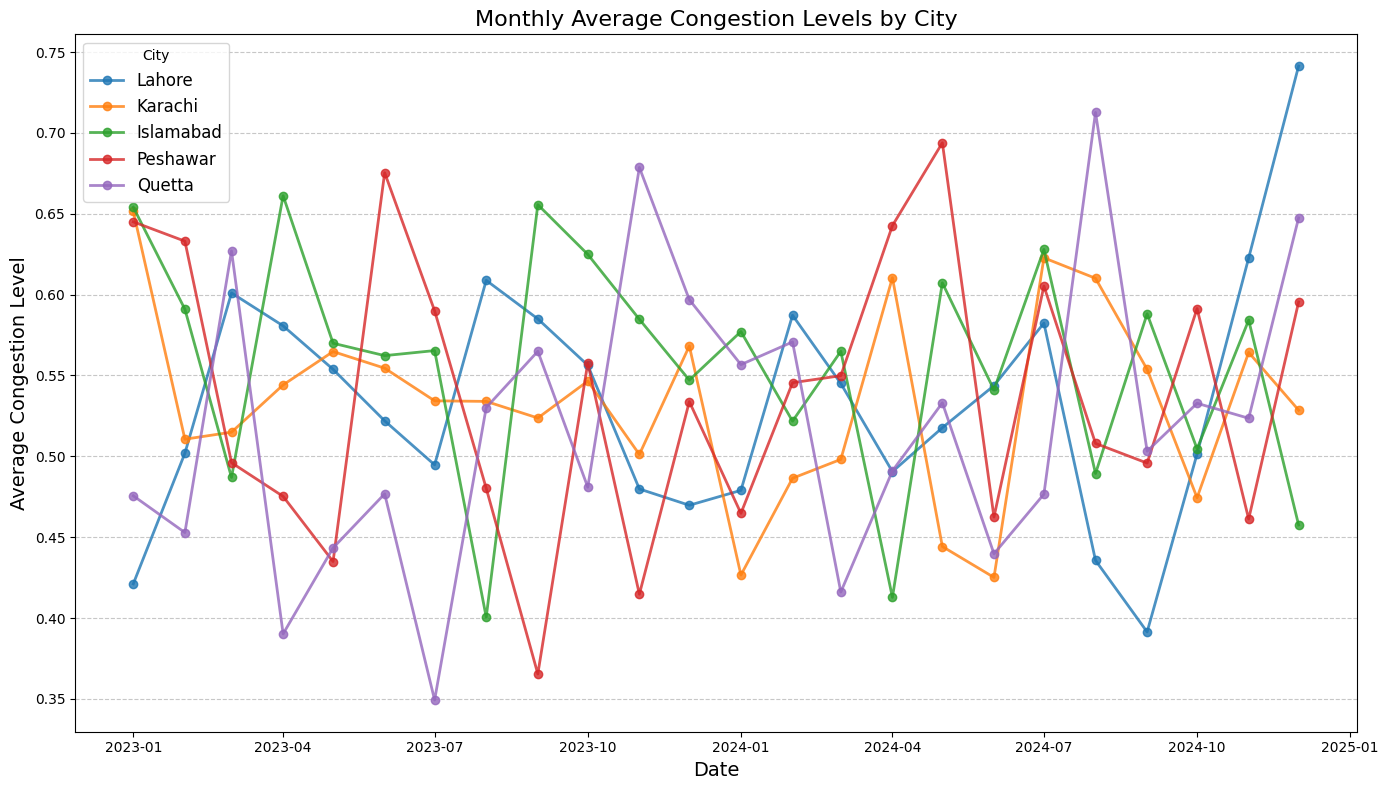

In [ ]:
plot_monthly_congestion_trends(historical_data_with_energy)


In [ ]:

def plot_interactive_congestion_trends(df):
    # Aggregate data by city and month
    df["month"] = df["timestamp"].dt.to_period("M")
    monthly_avg = df.groupby(["month", "location"])["congestion_level"].mean().reset_index()
    monthly_avg["month"] = monthly_avg["month"].dt.to_timestamp()

    fig = px.line(monthly_avg, x="month", y="congestion_level", color="location",
                  labels={"congestion_level": "Congestion Level", "month": "Date"},
                  title="Monthly Average Congestion Levels by City")
    fig.update_traces(mode="lines+markers", marker=dict(size=6))
    fig.update_layout(legend_title="City")
    fig.show()


In [ ]:
plot_interactive_congestion_trends(historical_data_with_energy)


In [ ]:
def perform_eda(df):
    # Describe the dataset
    print("\nDescriptive Statistics:")
    print(df.describe(include="all"))  # Include all columns

    # Compute the correlation matrix (only numeric columns)
    numeric_df = df.select_dtypes(include=["float64", "int64"])
    print("\nCorrelation Matrix:")
    correlation_matrix = numeric_df.corr()
    print(correlation_matrix)

    # Plot the correlation matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix")
    plt.show()



Descriptive Statistics:
       location            timestamp  congestion_level  \
count      3655                 3655       3655.000000   
unique        5                  NaN               NaN   
top      Lahore                  NaN               NaN   
freq        731                  NaN               NaN   
mean        NaN  2024-01-01 00:00:00          0.536525   
min         NaN  2023-01-01 00:00:00          0.000000   
25%         NaN  2023-07-02 00:00:00          0.244799   
50%         NaN  2024-01-01 00:00:00          0.488701   
75%         NaN  2024-07-02 00:00:00          0.738469   
max         NaN  2024-12-31 00:00:00          1.954455   
std         NaN                  NaN          0.369581   

        congestion_level_normalized  energy_consumption    month  
count                  3.655000e+03         3655.000000     3655  
unique                          NaN                 NaN       24  
top                             NaN                 NaN  2024-08  
freq      

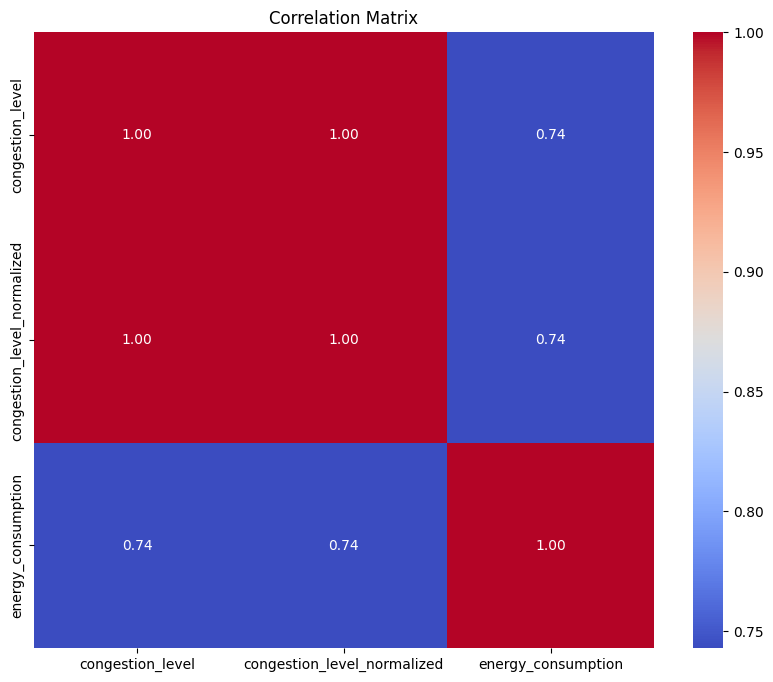

In [ ]:
perform_eda(historical_data_with_energy)